In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict, OrderedDict
from sklearn.metrics import adjusted_rand_score, auc
from scipy.stats import rankdata
import itertools

In [3]:
from pygraphs.cluster import KKMeans_vanilla as KKMeans, KWard, KMeans_sklearn, Ward_sklearn
from pygraphs.graphs.generator import StochasticBlockModel, RubanovModel
from pygraphs.measure import kernels, distances, scaler
from pygraphs.measure.kernel import Kernel
from pygraphs.scenario import ParallelByGraphs, RejectCurve, d3_colors, plot_results
from pygraphs.scorer import rand_index, triplet_measure, ranking

In [4]:
optimal_params_KKMeans = OrderedDict([  # for (100, 2, 0.3, 0.1)
    ('pWalk', 0.61),
    ('Walk', 0.37),
    ('For', 0.86),
    ('logFor', 0.12),
    ('Comm', 0.31),
    ('logComm', 0.53),
    ('Heat', 0.77),
    ('logHeat', 0.12),
    ('NHeat', 0.93),
    ('logNHeat', 0.93),
    ('SCT', 0.94),
    ('SCCT', 0.90),
    ('RSP', 0.71),
    ('FE', 0.47),
    ('PPR', 0.96),
    ('logPPR', 0.16),
    ('ModifPPR', 0.86),
    ('logModifPPR', 0.57),
    ('HeatPPR', 0.98),
    ('logHeatPPR', 0.96),
    ('SP-CT', 0.85)
])
optimal_params_KWard = OrderedDict([
    ('pWalk', 0.87),
    ('Walk', 0.74),
    ('For', 1.00),
    ('logFor', 0.54),
    ('Comm', 0.31),
    ('logComm', 0.56),
    ('Heat', 0.84),
    ('logHeat', 0.44),
    ('NHeat', 0.94),
    ('logNHeat', 0.97),
    ('SCT', 0.48),
    ('SCCT', 1.00),
    ('RSP', 0.98),
    ('FE', 0.93),
    ('PPR', 0.99),
    ('logPPR', 0.93),
    ('ModifPPR', 0.99),
    ('logModifPPR', 0.93),
    ('HeatPPR', 0.96),
    ('logHeatPPR', 0.96),
    ('SP-CT', 0.03)
])

In [5]:
graphs, _ = StochasticBlockModel(100, 2, p_in=0.3, p_out=0.1).generate_graphs(200)
y_true = [y_true_sample for A, y_true_sample in graphs]

In [6]:
def ravel(ari, optimal_params):
    return np.array(list(itertools.chain(*[ari[x] for x in optimal_params.keys()])))

def run_all_6(optimal_params, graphs, y_true):
    K = defaultdict(list)
    D = defaultdict(list)
    for kernel, distance in tqdm(zip(kernels, distances), total=len(kernels), desc='calc K'):
        for A, _ in graphs:
            param_flat = optimal_params[kernel.name]
            param = kernel(A).scaler.scale(param_flat)
            K[kernel.name].append(kernel(A).get_K(param))
            D[kernel.name].append(distance(A).get_D(param))
            
    KKMeans_ARI = defaultdict(list)
    for kernel_name, K_k in tqdm(K.items(), desc='KKMeans'):
        for idx, K_k_g in enumerate(K_k):
            y_pred = KKMeans(2).fit_predict(K_k_g)
            ari = adjusted_rand_score(y_true[idx], y_pred)
            KKMeans_ARI[kernel_name].append(ari)
    KKMeans_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KKMeans_ARI.items()])
#     sorted(KKMeans_ARI_mean.items(), key=lambda x: -x[1])
    
    KWard_ARI = defaultdict(list)
    for kernel_name, K_k in tqdm(K.items(), desc='KWard'):
        for idx, K_k_g in enumerate(K_k):
            y_pred = KWard(2).fit_predict(K_k_g)
            ari = adjusted_rand_score(y_true[idx], y_pred)
            KWard_ARI[kernel_name].append(ari)
    KWard_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KWard_ARI.items()])
#     sorted(KWard_ARI_mean.items(), key=lambda x: -x[1])
    
    KMeans_sklearn_ARI = defaultdict(list)
    for kernel_name, K_k in tqdm(K.items(), desc='KMeans_sklearn'):
        for idx, K_k_g in enumerate(K_k):
            y_pred = KMeans_sklearn(2).fit_predict(K_k_g)
            ari = adjusted_rand_score(y_true[idx], y_pred)
            KMeans_sklearn_ARI[kernel_name].append(ari)
    KMeans_sklearn_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KMeans_sklearn_ARI.items()])
#     sorted(KMeans_sklearn_ARI_mean.items(), key=lambda x: -x[1])
    
    Ward_sklearn_ARI = defaultdict(list)
    for kernel_name, K_k in tqdm(K.items(), desc='Ward_sklearn'):
        for idx, K_k_g in enumerate(K_k):
            y_pred = Ward_sklearn(2).fit_predict(K_k_g)
            ari = adjusted_rand_score(y_true[idx], y_pred)
            Ward_sklearn_ARI[kernel_name].append(ari)
    Ward_sklearn_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in Ward_sklearn_ARI.items()])
#     sorted(Ward_sklearn_ARI_mean.items(), key=lambda x: -x[1])
    
    rq_auc = defaultdict(list)
    for kernel_name, D_m in tqdm(D.items(), desc='RQ_AUC'):
        for idx, D_m_g in enumerate(D_m):
            tpr, fpr = RejectCurve._reject_curve(D_m_g, y_true[idx], need_shuffle=True)
            rq_auc[kernel_name].append(auc(tpr, fpr))
    rq_avg = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in rq_auc.items()])
#     sorted(rq_avg.items(), key=lambda x: -x[1])
    
    triplet = defaultdict(list)
    for kernel_name, D_k in tqdm(D.items(), desc='triplet'):
        for idx, D_k_g in enumerate(D_k):
            triplet[kernel_name].append(triplet_measure(y_true[idx], D_k_g))
    triplet_avg = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in triplet.items()])
#     sorted(triplet_avg.items(), key=lambda x: -x[1])

    return (
        ravel(KKMeans_ARI, optimal_params),
        ravel(KWard_ARI, optimal_params),
        ravel(KMeans_sklearn_ARI, optimal_params),
        ravel(Ward_sklearn_ARI, optimal_params),
        ravel(rq_auc, optimal_params),
        ravel(triplet, optimal_params)
    )

# Triplet measure vs in-out AUC vs k-means ARI

Эксперимент с ранговыми корреляциями триплетного скора (берем все тройки, где 2 из 3 семплов относятся к одному классу, проверяем условие d(s1, s2) < d(s1, s3), мера – доля правильных ответов) vs in-out AUC vs k-means ARI.

## For optimal params for KKMeans

Сначала насчитаем все кернелы по заранее определенным оптимальным параметрам

In [7]:
chain_KKMeans = run_all_6(optimal_params_KKMeans, graphs, y_true)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

In [8]:
chain_of_chains = chain_KKMeans
a = defaultdict(lambda: defaultdict(lambda: 0))
for i1, c1 in enumerate(chain_of_chains):
    for i2, c2 in enumerate(chain_of_chains):
        a[i1][i2] = ranking(c1, c2)
data = np.array([[np.abs(a[i][j]) for j in range(6)] for i in range(6)])

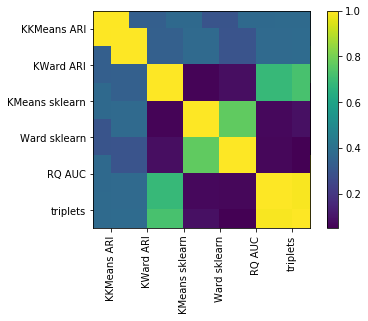

In [9]:
plt.imshow(data, vmin=0, vmax=1)
plt.xticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets'], rotation='vertical')
plt.yticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets']);

heatmap = plt.pcolor(data)
plt.imshow(data)
plt.colorbar(heatmap)

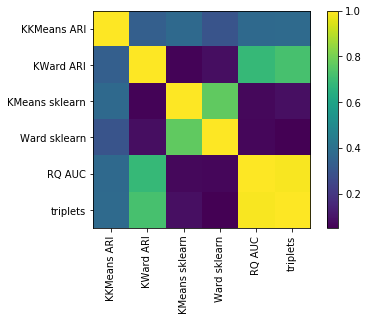

In [10]:
plt.imshow(data, vmin=0, vmax=1)
plt.xticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets'], rotation='vertical')
plt.yticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets']);

plt.imshow(data)
plt.colorbar(heatmap)

## For KWard optimal params

In [11]:
chain_KWard = run_all_6(optimal_params_KWard, graphs, y_true)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

In [12]:
chain_of_chains = chain_KWard
a = defaultdict(lambda: defaultdict(lambda: 0))
for i1, c1 in enumerate(chain_of_chains):
    for i2, c2 in enumerate(chain_of_chains):
        a[i1][i2] = ranking(c1, c2)
data = np.array([[np.abs(a[i][j]) for j in range(6)] for i in range(6)])

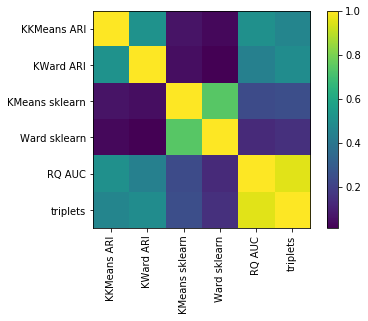

In [14]:
plt.imshow(data, vmin=0, vmax=1)
plt.xticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets'], rotation='vertical')
plt.yticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets']);

plt.imshow(data)
plt.colorbar(heatmap)

# combine both things

In [19]:
chain_of_chains = chain_KKMeans + chain_KWard
a = defaultdict(lambda: defaultdict(lambda: 0))
for i1, c1 in enumerate(chain_of_chains):
    for i2, c2 in enumerate(chain_of_chains):
        a[i1][i2] = ranking(c1, c2)
data = np.array([[np.abs(a[i][j]) for j in range(12)] for i in range(12)])

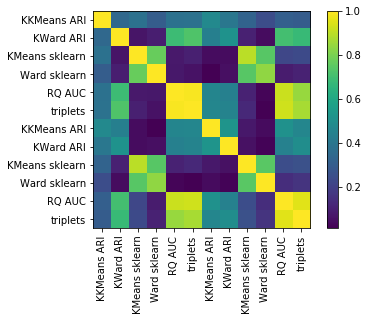

In [20]:
plt.imshow(data, vmin=0, vmax=1)
plt.xticks(range(12), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets',
                      'KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets'], rotation='vertical')
plt.yticks(range(12), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets',
                      'KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'RQ AUC', 'triplets']);

plt.imshow(data)
plt.colorbar(heatmap)

In [35]:
all_names = np.array(['KKMeans ARI, o1', 'KWard ARI, o1', 'KMeans sk, o1', 'Ward sk, o1', 'RQ AUC, o1', 'triplets, o1',
             'KKMeans ARI, o2', 'KWard ARI, o2', 'KMeans sk, o2', 'Ward sk, o2', 'RQ AUC, o2', 'triplets, o2'])

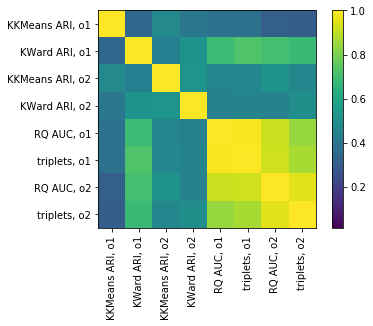

In [42]:
indices = [0, 1, 6, 7, 4, 5, 10, 11]
names = all_names[indices]

plt.imshow(data[indices][:, indices], vmin=0, vmax=1)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.yticks(range(len(names)), names);

plt.colorbar(heatmap)

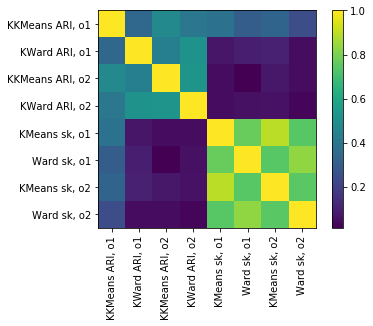

In [43]:
indices = [0, 1, 6, 7, 2, 3, 8, 9]
names = all_names[indices]

plt.imshow(data[indices][:, indices], vmin=0, vmax=1)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.yticks(range(len(names)), names);

plt.colorbar(heatmap)